## Theoretical Result 

### Checking

We need to check for three conditions:

1. Survival Probability $\frac{d}{b} \frac{1}{\epsilon K} + \frac{r}{b}$ is close to $\frac{r}{b}$, where we calculate $\frac{d}{b} \frac{1}{\epsilon K} \left/ \frac{r}{b} \right.$ and call this value the `excess survival rate`, we want it to be small enough.

2. Consistency: $1 - \exp(-\frac{r e^{-rt} \epsilon K}{b})$, we want this to be close to 1. We check this under time $T
$, which is the time need to growth from $1$ to $\epsilon K$ using determinstic dynamics.

3. Mutation probability in range $[0, \tau] \le 1 - \exp(-\frac{v\epsilon K}{r}(\gamma + \ln(\frac{r\epsilon K}{b})))$ : we want this to be small enough.

Using parameter listed below, we check these condition for several choice of $\epsilon$. 

In [1]:
from theorem import *
%matplotlib inline

alpha = {"division":1.75, "death":0, "pasym":0.9, "psym":0.0525, "dsym":0.1-0.0525,
         "adjust":1e-2, "v":1e-6, "K":10**9.3, "dd":1.14794853, "dp":2.12*1e-3, "dm":5*1e-6,
         "l_ratio":0.15/(1.6+0.15), "pow":0.4117, "eps":1e-5}

`alpha` is the dictionary to save our parameters, And we use conditional probability $p_{G,U}$ to be $4/(1+|F|) : 7/(1+|S|) : 4$ for $F, S, M$ which is the same as in simulation code. And the changing of parameters under mutation is also the same as in simulation codes.

Then let's do the checks of conditions:

In [2]:
TestNULL = tissue(alpha, pGUfunc2, 52*80,52*80*10)
print(TestNULL.para)

Excess Survival ratio: 0.0004761278719459091
P(mutiation in [0,tao]): 0.08894743721510245
Init time to grow to size eps*K: 21.80 years
Approximation Consistency:  0.08915853364391768
{'b': 0.091875, 'd': 0.08312500000000002, 'r': 0.00874999999999998, 'K': 1995262314.9688828, 'G': 41600, 'va': 5e-09, 'vs': 1e-08, 'v': 5.025e-09}


As you can see above: `Excess Survival ratio` is the first term. `Approximation Consistency` is the second condition and `P(mutiation in [0,tao])` is the last. `Init time to grow to size eps*K` is num years to growth to size $\epsilon K$ under determinstic dynamics. Also you can see a dictionary containing model parameters $r,b,d,K, v_a, v_s, v$ and gene type $G$.

Even `Excess Survival ratio` and `P(mutiation in [0,tao])` are reasonable small, but `Approximation Consistency` is far away from 1. This may be because growth time $T$ is large (22 years) and $r / b$ is small. 

If we change $\epsilon$ to other values, the results are following:

In [3]:
alpha["eps"] = 1e-6
TestNULL = tissue(alpha, pGUfunc2, 52*80,52*80*10)
print(TestNULL.para)

Excess Survival ratio: 0.004761278719459091
P(mutiation in [0,tao]): 0.0066548079709829455
Init time to grow to size eps*K: 16.72 years
Approximation Consistency:  0.09016676239647026
{'b': 0.091875, 'd': 0.08312500000000002, 'r': 0.00874999999999998, 'K': 1995262314.9688828, 'G': 41600, 'va': 5e-09, 'vs': 1e-08, 'v': 5.025e-09}


In [5]:
alpha["eps"] = 1e-7
TestNULL = tissue(alpha, pGUfunc2, 52*80,52*80*10)
print(TestNULL.para)

Excess Survival ratio: 0.047612787194590916
P(mutiation in [0,tao]): 0.0004037815909366804
Init time to grow to size eps*K: 11.65 years
Approximation Consistency:  0.09057946281081819
{'b': 0.091875, 'd': 0.08312500000000002, 'r': 0.00874999999999998, 'K': 1995262314.9688828, 'G': 41600, 'va': 5e-09, 'vs': 1e-08, 'v': 5.025e-09}


In [7]:
alpha["eps"] = 1e-4
TestNULL = tissue(alpha, pGUfunc2, 52*80,52*80*10)
print(TestNULL.para)

Excess Survival ratio: 4.76127871945909e-05
P(mutiation in [0,tao]): 0.6974136888204194
Init time to grow to size eps*K: 26.93 years
Approximation Consistency:  0.08655511474085387
{'b': 0.091875, 'd': 0.08312500000000002, 'r': 0.00874999999999998, 'K': 1995262314.9688828, 'G': 41600, 'va': 5e-09, 'vs': 1e-08, 'v': 5.025e-09}


In [8]:
alpha["eps"] = 1e-3
TestNULL = tissue(alpha, pGUfunc2, 52*80,52*80*10)
print(TestNULL.para)

Excess Survival ratio: 4.76127871945909e-06
P(mutiation in [0,tao]): 0.9999995401225386
Init time to grow to size eps*K: 32.18 years
Approximation Consistency:  0.07983625483364265
{'b': 0.091875, 'd': 0.08312500000000002, 'r': 0.00874999999999998, 'K': 1995262314.9688828, 'G': 41600, 'va': 5e-09, 'vs': 1e-08, 'v': 5.025e-09}


As you can see, `Approximation Consistency` is like a constant and far away from $1$. This may be because $e^{-rt} \epsilon K$ is close to 1. Therefore condition 2 can not be easily held.

### Results

The result in a careful selected parameters is shown below. And notice that in caculation and for every plot we delet first 21.8 years which is the growth time to $\epsilon K$ because we assume there's no mutation happened in this range.

In [11]:
alpha["eps"] = 1e-5
TestNULL = tissue(alpha, pGUfunc2, 52*80,52*80*10)
solution = TestNULL.solve()
print("Done")

Excess Survival ratio: 0.0004761278719459091
P(mutiation in [0,tao]): 0.08894743721510245
Init time to grow to size eps*K: 21.80 years
Approximation Consistency:  0.08915853364391768
S  SS  SSS  SSF  SSM  SF  SFS  SFF  SFM  SM  SMS  SMF  SMM  F  FS  FSS  FSF  FSM  FF  FFS  FFF  FFM  FM  FMS  FMF  FMM  M  MS  MSS  MSF  MSM  MF  MFS  MFF  MFM  MM  MMS  MMF  MMM  
Done


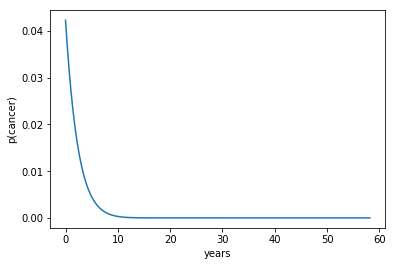

In [14]:
plt.plot(TestNULL.ts/52, 1-solution[""], label='Line 1')
plt.xlabel("years")
plt.ylabel("p(cancer)")
plt.show()

Also we can plot this type of probability curve of getting cancer condition on the given initial Genetype:

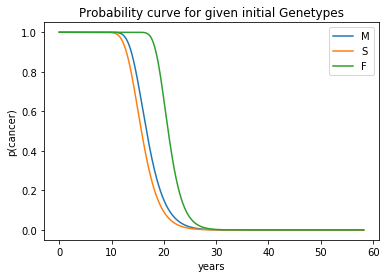

In [15]:
M, = plt.plot(TestNULL.ts/52, 1-solution["M"], label='Line 1')
S, = plt.plot(TestNULL.ts/52, 1-solution["S"], label='Line 2')
F, = plt.plot(TestNULL.ts/52, 1-solution["F"], label='Line 3')
plt.legend([M,S,F], ['M','S','F'])
plt.xlabel("years")
plt.ylabel("p(cancer)")
plt.title("Probability curve for given initial Genetypes")
plt.show()

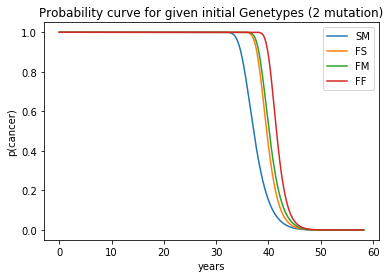

In [16]:
SM, = plt.plot(TestNULL.ts/52, 1-solution["SM"], label='Line 1')
FS, = plt.plot(TestNULL.ts/52, 1-solution["FS"], label='Line 2')
FM, = plt.plot(TestNULL.ts/52, 1-solution["FM"], label='Line 3')
FF, = plt.plot(TestNULL.ts/52, 1-solution["FF"], label='Line 4')
plt.legend([SM,FS,FM,FF], ['SM','FS','FM','FF'])
plt.xlabel("years")
plt.ylabel("p(cancer)")
plt.title("Probability curve for given initial Genetypes (2 mutation)")
plt.show()

### Conclusion

We may need a better model.